# 0. Load Libraries

In [1]:
import json
import numpy as np
import pandas as pd
import models
import utils
from matplotlib import pyplot as plt
from classes import  Locatable, Satellite, Cluster, Vehicle
from drawingmap import DrawingMap

# 1. Load Data

## 1.1. Satellites

In [2]:
satellites, df_satellites = utils.LoadingData.load_satellites(DEBUG=False)
print(f'Cantidad de satellites cargados: {len(satellites)}')

Cantidad de satellites cargados: 9


## 1.2. Customer Clusters

In [3]:
clusters, df_clusters = utils.LoadingData.load_customer_clusters(DEBUG=False)
print(f'Cantidad de clusters cargados: {len(clusters)}')

Cantidad de clusters cargados: 721


## 1.3. Load Vehicles

In [4]:
small_vehicle = Vehicle(id='small'
                        , type='small'
                        , capacity=115
                        , costFixed=2
                        , time_service=0.05
                        , time_fixed=0.05
                        , time_load=0.0072
                        , time_dispatch=0.625
                        , speed_line=40
                        , Tmax=12
                        , k=1.3)
large_vehicle = Vehicle(id='large'
                        , type='large'
                        , capacity=456
                        , costFixed=8
                        , time_service=0.05
                        , time_fixed=0.05
                        , time_load=0.0142
                        , time_dispatch=0.75
                        , speed_line=40
                        , Tmax=12
                        , k=1.3)

## 1.4. Load Matrixes: Distance and Durations with and without traffic

### 1.4.1. From Satellites to Clusters

In [5]:
matrixes_from_satellites = utils.LoadingData.load_distances_duration_matrix_from_satellite()

### 1.4.2. From DC to Clusters

In [6]:
matrixes_from_dc = utils.LoadingData.load_distances_duration_matrix_from_dc()

# 2. Drawing Map

## 2.1. La Paz with customer segments

In [7]:
location_la_paz = (-16.501457, -68.149887)
location_DC = (-16.5354544, -68.1958506)

drawer = DrawingMap(location_la_paz)

drawer.addNodes(list_locatables=list(clusters.values()), color="blue", radius=4)
drawer.addNodes(list_locatables=list(satellites.values()), color='red', radius=6)
drawer.addMarker(location=location_DC, label='DC')

map = drawer.viewMap()
map

# 3. Generate Params

In [8]:
PERIODS = 12
params_gurobi = {
    'TimeLimit':1000,
    'MIPGap':0.01
}

## 3.1. Average Fleet Size
#### a) From Satellite to Customer Cluster

In [9]:
config_ = utils.ConfigDeterministic()
fleet_size_satellites = config_.calculate_avg_fleet_size_from_satellites(satellites=list(satellites.values())
                                                                         , clusters=list(clusters.values())
                                                                         , vehicle=small_vehicle
                                                                         ,periods=PERIODS, distances_linehaul=matrixes_from_satellites['distance'])

#### b) From DC to Customer Cluster

In [10]:
fleet_size_dc = config_.calculate_avg_fleet_size_from_dc(clusters=clusters.values(), vehicle=large_vehicle, periods=PERIODS
                                                         , distances_linehaul=matrixes_from_dc['distance'])

In [11]:
fleet_size_required = {
    'small': fleet_size_satellites,
    'large': fleet_size_dc
}

## 3.3. Cost *$c_{sk}^{t}$* and *$g_{k}{t}$*
### 3.3.1. Avg distance from satellites

In [12]:
distance_average_from_satellites = {}
for s in satellites.values():
    min_distances, max_distances = 100000000, -1
    for k in clusters.values():
        min_distances = min_distances if matrixes_from_satellites['distance'][(s.id, k.id)] > min_distances else matrixes_from_satellites['distance'][(s.id, k.id)]
        max_distances = max_distances if matrixes_from_satellites['distance'][(s.id, k.id)] < max_distances else matrixes_from_satellites['distance'][(s.id, k.id)]
    distance_average_from_satellites[s.id] = {'min': min_distances, 'max': max_distances, 'interval': max_distances-min_distances, 'cost': 0.421 - 0.335}
#distance_average_from_satellites

### 3.3.2. Avg distances from dc

In [13]:
distance_average_from_dc = {}
min_distances, max_distances = 100000000, -1
for k in clusters.values():
    min_distances = min_distances if matrixes_from_dc['distance'][(k.id)] > min_distances else matrixes_from_dc['distance'][(k.id)]
    max_distances = max_distances if matrixes_from_dc['distance'][(k.id)] < max_distances else matrixes_from_dc['distance'][(k.id)]
distance_average_from_dc = {'min': min_distances, 'max': max_distances, 'interval': max_distances-min_distances, 'cost': 0.389 - 0.264}
#distance_average_from_dc

## 3.3. Cost of Shipping based in fixed-fee

In [14]:
fee_cost_from_satellites = 0.389 #0.071
fee_cost_from_dc = 0.335 #0.06

cost_shipping_from_satellites = dict([
    ((s.id, k.id), distance_average_from_satellites[(s.id)]['cost']/distance_average_from_satellites[(s.id)]['interval']*\
     (matrixes_from_satellites['distance'][(s.id, k.id)] - distance_average_from_satellites[(s.id)]['min']) +  0.335) for s in satellites.values() for k in clusters.values()
])

cost_shipping_from_dc = dict([
    (k.id, distance_average_from_dc['cost']/distance_average_from_dc['interval']* (matrixes_from_dc['distance'][(k.id)] - distance_average_from_dc['min']) +  0.264)for k in clusters.values()
])

SATELLITES: max: 0.421 - min: 0.335 - mean 0.373
DC: max: 0.389 - min: 0.264 - mean 0.328


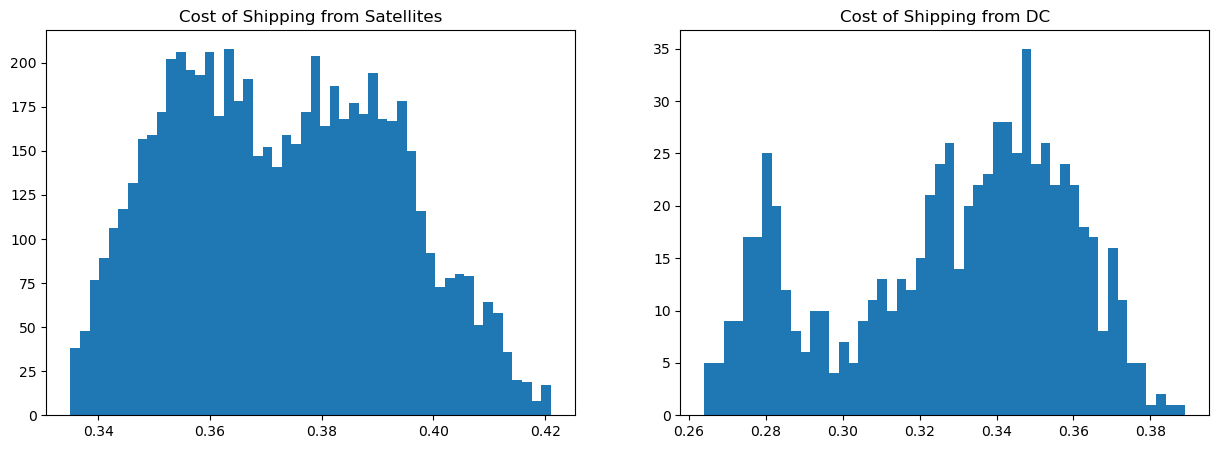

In [15]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# ax-1
aux_1 = [item for item in list(cost_shipping_from_satellites.values()) if item!=0]
# ax-2
aux_2 = [item for item in list(cost_shipping_from_dc.values()) if item!=0]
print(f'SATELLITES: max: {np.max(aux_1):.3f} - min: {np.min(aux_1):.3f} - mean {np.mean(aux_1):.3f}')
print(f'DC: max: {np.max(aux_2):.3f} - min: {np.min(aux_2):.3f} - mean {np.mean(aux_2):.3f}')
axes[0].hist(aux_1, bins=50)
axes[0].set_title("Cost of Shipping from Satellites")
axes[1].hist(aux_2, bins=50)
axes[1].set_title('Cost of Shipping from DC')
plt.show()

## 3.4. Operational Total Cost

In [16]:
def cost_satellite_cluster_period(satellites: list[Satellite],
                                  clusters: list[Cluster],
                                  cost_shipping_satellite: dict[(str, str), float],
                                  vehicle_small: Vehicle,
                                  periods: int,
                                  vehicles_required: dict[str, dict]) -> dict[(str,str,int), float]:
    costs = {}
    for t in range(periods):
        for k in clusters:
            for s in satellites:
                cost_first_level = (s.costSourcing*k.demandByPeriod[t])
                cost_shipping = (cost_shipping_satellite[(s.id, k.id)]*k.demandByPeriod[t])
                cost_vehicles = 0 #(vehicle_small.costFixed*vehicles_required['small'][(s.id, k.id, t)]['fleet_size'])
                total_cost = cost_first_level + cost_shipping + cost_vehicles
                costs[(s.id, k.id, t)] = {'total': total_cost, 'first_level': cost_first_level
                                        ,'shipping': cost_shipping, 'vehicles':cost_vehicles}
    return costs

def cost_dc_cluster_period(clusters: list[Cluster],
                           cost_shipping_dc: dict[str, float],
                           vehicle_large: Vehicle,
                           periods: int,
                           vehicles_required: dict[str, dict]) -> dict[(str,int), float]:
    costs = {}
    for t in range(periods):
        for k in clusters:
            cost_shipping =(cost_shipping_dc[k.id] * k.demandByPeriod[t]) 
            cost_vehicles = 0 #(vehicle_large.costFixed * vehicles_required['large'][(k.id, t)]['fleet_size'])
            total_cost = cost_shipping + cost_vehicles 
            costs[(k.id, t)] = {'total': total_cost, 'shipping': cost_shipping, 'vehicles': cost_vehicles}
    return costs

In [17]:
cost_C = cost_satellite_cluster_period(list(satellites.values()), list(clusters.values())
                                       ,cost_shipping_satellite=cost_shipping_from_satellites
                                       ,vehicle_small=small_vehicle
                                       ,periods=PERIODS
                                       ,vehicles_required=fleet_size_required)

cost_G = cost_dc_cluster_period(clusters.values()
                                ,cost_shipping_dc=cost_shipping_from_dc
                                ,vehicle_large=large_vehicle
                                ,periods=PERIODS
                                ,vehicles_required=fleet_size_required)

max: 223.06045253816302 - min: 0.014538591323514679 - mean 3.6696869072544223


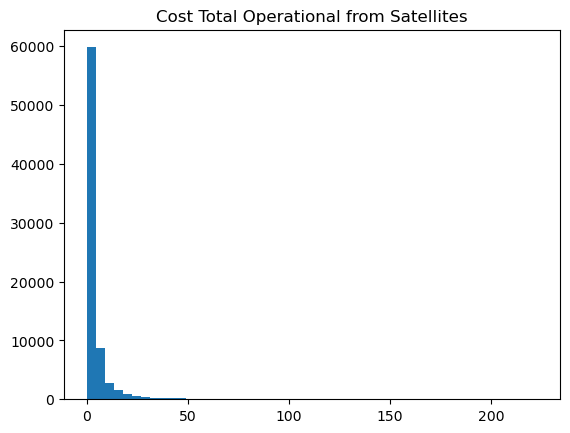

In [18]:
aux = [item['total'] for item in list(cost_C.values()) if item['total']!=0]
print(f'max: {np.max(aux)} - min: {np.min(aux)} - mean {np.mean(aux)}')
plt.hist(aux, bins=50)
plt.title("Cost Total Operational from Satellites")
plt.show()

max: 91.56100880143113 - min: 0.006654797682937218 - mean 1.5373640732348517


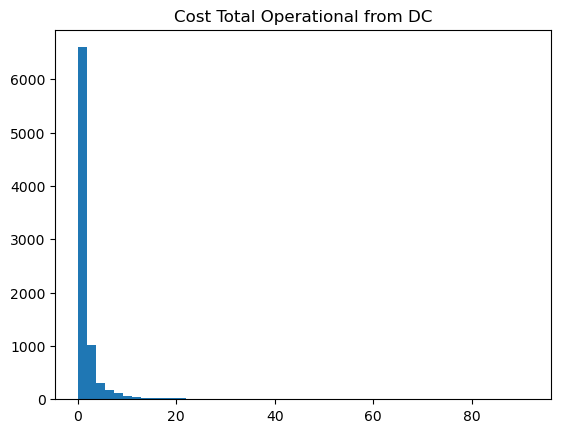

In [19]:
aux = [item['total'] for item in list(cost_G.values()) if item['total']!=0]
print(f'max: {np.max(aux)} - min: {np.min(aux)} - mean {np.mean(aux)}')
plt.hist(aux, bins=50)
plt.title("Cost Total Operational from DC")
plt.show()

## 3.5. Income per Satellite and Cluster

In [20]:
fee_required_from_satellite = 89 #89
fee_required_from_cd = 119 #119

income = dict([
    ((s.id, k.id, t),
     k.demandByPeriod[t]*cost_shipping_from_satellites[(s.id, k.id)] - fleet_size_satellites[(s.id, k.id,t)]['fleet_size']*fee_required_from_satellite
    ) for s in list(satellites.values()) for k in list(clusters.values()) for t in range(PERIODS)
])

In [21]:
cost_operation = {
    'satellite': cost_C,
    'dc': cost_G,
    'min_items_satellite': 115, # 155
    'min_items_dc': 290, #290,
    'fee_required_from_satellite': fee_required_from_satellite,
    'fee_required_from_dc': fee_required_from_cd
}

# 4. Model Deterministic

In [22]:
model_ = models.ModelDeterministic(periods=PERIODS)
model_.setParams(params=params_gurobi)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-13
Set parameter TimeLimit to value 1000
Set parameter MIPGap to value 0.01


In [23]:
model_.build(satellites=list(satellites.values())
             ,clusters=list(clusters.values())
             ,vehicles_required=fleet_size_required
             ,costs=cost_operation)

Discarded solution information
1) add WALDO constraints
2) W to Zero


{'time_building': 1}

In [24]:
print(model_.optimizeModel())

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 95517 rows, 86682 columns and 412156 nonzeros
Model fingerprint: 0xb2389cbc
Variable types: 0 continuous, 86682 integer (86682 binary)
Coefficient statistics:
  Matrix range     [1e-05, 2e+02]
  Objective range  [7e-03, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 41514.321603
Presolve removed 10974 rows and 10731 columns
Presolve time: 0.61s
Presolved: 84543 rows, 75951 columns, 380205 nonzeros
Variable types: 0 continuous, 75951 integer (75951 binary)
Found heuristic solution: objective 40076.906560
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   71228    3.2783059e+04   0.000000e+00   3.594775e+05      5

In [25]:
cost_allocation_satellites = np.sum([
    (s.costFixed[q_id]/25) * model_.Y[(s.id, q_id)].x for s in list(satellites.values()) for q_id in s.capacity.keys()
])
cost_operating_satellites = np.sum([
    (s.costOperation[t]/25) * model_.X[(s.id, t)].x for s in list(satellites.values()) for t in range(PERIODS)
])
cost_served_from_satellite = np.sum([
    cost_operation['satellite'][(s.id, k.id, t)]['total'] * model_.Z[(s.id, k.id, t)].x for s in list(satellites.values()) for k in
    list(clusters.values()) for t in
    range(PERIODS)
])
cost_served_from_dc = np.sum([
    cost_operation['dc'][(k.id, t)]['total'] * model_.W[(k.id, t)].x for k in list(clusters.values()) for t in range(PERIODS)
])

In [26]:
total_cost = cost_allocation_satellites + cost_operating_satellites + cost_served_from_satellite + cost_served_from_dc
print(f'cost allocation satellites: {cost_allocation_satellites:.2f} ({(cost_allocation_satellites*100/total_cost):.2f} %)\n'+\
    f'cost operating satellites: {cost_operating_satellites:.2f} ({(cost_operating_satellites*100/total_cost):.2f} %)\n'+\
    f'cost served from satellite: {cost_served_from_satellite:.2f} ({(cost_served_from_satellite*100/total_cost):.2f} %)\n'+\
    f'cost served from dc: {cost_served_from_dc:.2f} ({(cost_served_from_dc*100/total_cost):.2f} %)')

cost allocation satellites: 1040.00 (3.18 %)
cost operating satellites: 1253.60 (3.83 %)
cost served from satellite: 30401.13 (92.98 %)
cost served from dc: 0.00 (0.00 %)


## 4.1. Get results

In [27]:
variables_results = model_.get_results(satellites=list(satellites.values())
                                      ,clusters=list(clusters.values()))

### 4.1.1. Y

In [28]:
for k, v in variables_results['Y'].items():
    print(f'id: {k[0]} cap: {k[1]}')

id: Abaroa cap: 20
id: Perferica cap: 5
id: Los Pinos cap: 5


### 4.1.2. X

In [29]:
for t in range(PERIODS):
    print(f'## t - {t}', end=" ")
    for k, v in variables_results['X'][t].items():
        print(f'id: {v.id}', end=" | ")
    print("")

## t - 0 id: Abaroa | 
## t - 1 id: Abaroa | 
## t - 2 id: Abaroa | 
## t - 3 id: Abaroa | 
## t - 4 id: Abaroa | 
## t - 5 id: Abaroa | 
## t - 6 id: Abaroa | 
## t - 7 id: Abaroa | 
## t - 8 id: Abaroa | id: Perferica | 
## t - 9 id: Abaroa | id: Los Pinos | 
## t - 10 id: Abaroa | id: Los Pinos | 
## t - 11 id: Abaroa | id: Perferica | id: Los Pinos | 


### 4.1.3. W - demand served from DC

In [30]:
period_selected = 0
lista_clusters = variables_results['W'][period_selected]
# map
location_la_paz = (-16.501457, -68.149887)
location_DC = (-16.5354544, -68.1958506)
drawer = DrawingMap(location_la_paz)
drawer.addNodes(list_locatables=lista_clusters, color="black", radius=3)
drawer.addMarker(location=location_DC, label='DC')
drawer.viewMap()

### 4.1.4. Z - demand served from DC

In [31]:
map_colors = {
    'Abaroa': 'blue',
    'Llojeta': 'green',
    'Cota Cota': 'orange',
    'Achachicala': 'darkgreen',
    'Mallasa': 'black',
    'Sopocachi': 'gray',
    'Perferica': 'darkred',
    'Zona Cementerio': 'pink',
    'Los Pinos': 'purple'
}

In [32]:
period_selected = 0
location_DC = (-16.5354544, -68.1958506)
drawer = DrawingMap(location_la_paz)
for k, v in map_colors.items():
    satellite_selected = k
    lista_clusters = variables_results['Z'][period_selected][satellite_selected]
    if len(lista_clusters) == 0:
        continue
    # map
    drawer.addNodes(list_locatables=lista_clusters, color=v, radius=3)
    drawer.addMarker(location=(satellites[satellite_selected].lat, satellites[satellite_selected].lon), label=satellite_selected)

lista_clusters = variables_results['W'][period_selected]
drawer.addNodes(list_locatables=lista_clusters, color="black", radius=3)
drawer.addMarker(location=location_DC, label='DC')
drawer.viewMap()

## 4.2. Metrics

### 4.2.1. Vehicles Required

In [33]:
def obtain_vehicles_required_in_satellite(satellite: Satellite, clusters_served: list[Cluster], period: int, vehicles_required: dict[(str, str, t), float]):
    vehicles_sum = 0
    for c in clusters_served:
        vehicles_sum += vehicles_required[(satellite.id, c.id, period)]['fleet_size']
    return vehicles_sum
vehicles_required_results = dict([
    (s.id, [obtain_vehicles_required_in_satellite(s
                                     ,clusters_served=variables_results['Z'][t][s.id]
                                     ,period=t
                                     ,vehicles_required=fleet_size_satellites) for t in range(PERIODS)]) for s in list(satellites.values())
])
df_vehicles_satellite = pd.DataFrame(vehicles_required_results)
df_vehicles_satellite
#print(json.dumps(vehicles_required_results, indent=2))

,Abaroa,Llojeta,Cota Cota,Achachicala,Mallasa,Sopocachi,Perferica,Zona Cementerio,Los Pinos
0,16.622683,0,0,0,0,0,0.000000,0,0.000000
1,15.783439,0,0,0,0,0,0.000000,0,0.000000
2,11.463122,0,0,0,0,0,0.000000,0,0.000000
3,9.609122,0,0,0,0,0,0.000000,0,0.000000
4,12.214434,0,0,0,0,0,0.000000,0,0.000000
5,15.111472,0,0,0,0,0,0.000000,0,0.000000
6,16.318946,0,0,0,0,0,0.000000,0,0.000000
7,13.546338,0,0,0,0,0,0.000000,0,0.000000
8,15.135756,0,0,0,0,0,4.999816,0,0.000000
9,19.374581,0,0,0,0,0,0.000000,0,4.999789


In [34]:
def obtain_vehicles_required_in_dc(clusters_served: list[Cluster], period: int, vehicles_required: dict[(str, t), float]):
    vehicles_sum = 0
    for c in clusters_served:
        vehicles_sum += vehicles_required[(c.id, period)]['fleet_size']
    return vehicles_sum

vehicles_required_results =[ obtain_vehicles_required_in_dc(clusters_served=variables_results['W'][t]
                                                  ,period=t
                                                  ,vehicles_required=fleet_size_dc) for t in range(PERIODS)
]
df_vehicles_dc = pd.DataFrame(vehicles_required_results, columns=['DC'])
df_vehicles_dc
#print(json.dumps(vehicles_required_results, indent=2))

,DC
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


### 4.2.2. % Demand served from Satellites

In [35]:
demand_by_period = []
for t in range(PERIODS):
    sum_ = 0
    for c in list(clusters.values()):
        sum_ += c.demandByPeriod[t]
    demand_by_period.append(sum_)
df_demand_dc = pd.DataFrame(demand_by_period, columns=['DC'])
df_demand_dc

,DC
0,3194.200
1,3288.603
2,2481.951
3,2159.172
4,2590.479
5,3209.395
6,3320.816
7,2723.128
8,3742.223
9,4455.867


In [36]:
resumen ={}
for s in list(satellites.values()):
    demand_served = []
    for t in range(PERIODS):
        sum_ = 0
        for c in variables_results['Z'][t][s.id]:
            sum_ += c.demandByPeriod[t]
        demand_served.append(sum_)
    per_demand_served = np.round(np.array(demand_served) / np.array(demand_by_period),2)
    resumen[s.id] = {
        'demand_served': demand_served,
        'per_demand_served': per_demand_served.tolist()
    }
df_demand_satellite = pd.DataFrame(resumen).T
print("FROM SATELLITES: ")
df_demand_satellite
#print(json.dumps(resumen, indent=2))

FROM SATELLITES: 


,demand_served,per_demand_served
Abaroa,"[3194.1999999999953, 3288.602999999995, 2481.9...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.72,..."
Llojeta,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Cota Cota,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Achachicala,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Mallasa,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Sopocachi,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Perferica,"[0, 0, 0, 0, 0, 0, 0, 0, 1055.126, 0, 0, 1011....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28,..."
Zona Cementerio,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Los Pinos,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1014.9130000000006...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### 4.2.3. % Demand served from DC

In [37]:
demand_served = []
for t in range(PERIODS):
    sum_ = 0
    for c in variables_results['W'][t]:
        sum_ += c.demandByPeriod[t]
    demand_served.append(sum_)
per_demand_served = np.round(np.array(demand_served) / np.array(demand_by_period),2)
resumen = {
    'demand_served': demand_served,
    'per_demand_served': per_demand_served.tolist()
}
df_demand_dc = pd.DataFrame(resumen).T
print("FROM DC: ")
df_demand_dc
#print(json.dumps(resumen, indent=2))

FROM DC: 


,0,1,2,3,4,5,6,7,8,9,10,11
demand_served,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
per_demand_served,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
fleet_size_satellites

{('Abaroa', '89b3218b083ffff', 0): {'fleet_size': 0.00473471683969269,
  'avg_tour_time': 17.672205636625346,
  'fully_loaded_tours': 0.5965188461555966,
  'effective_capacity': 113.30049261083745,
  'demand_served': 1.16,
  'avg_drop': 1.015,
  'avg_stop_density': 0.32},
 ('Abaroa', '89b3218b093ffff', 0): {'fleet_size': 0.00036033159596994427,
  'avg_tour_time': 308.34357152407694,
  'fully_loaded_tours': 0.03861177768996248,
  'effective_capacity': 2875.0,
  'demand_served': 0.04,
  'avg_drop': 0.04,
  'avg_stop_density': 0.04},
 ('Abaroa', '89b3218b09bffff', 0): {'fleet_size': 0.0007518137155807598,
  'avg_tour_time': 159.64965742210134,
  'fully_loaded_tours': 0.07402388751321647,
  'effective_capacity': 1437.5,
  'demand_served': 0.08,
  'avg_drop': 0.08,
  'avg_stop_density': 0.08},
 ('Abaroa', '89b3218b0abffff', 0): {'fleet_size': 0.004283227778347879,
  'avg_tour_time': 21.166142428365678,
  'fully_loaded_tours': 0.5067287790718132,
  'effective_capacity': 147.43589743589743,
 